- преобразовать в py
- попросить gpt 
    - явно сказать, что это ноутбук, преобразованный в py
    - убрать дублирование кода
    - повторяющиеся куски кода обернуть в функции с осмысленными названиями, переменными и схемами аргументов и возвращаемого значения
    - фунцкии вынести в отдельный файл scripts.py
    - добавить докстринги к функциям на английском
    - 

In [1]:
import pyomo.environ as pyo
import numpy as np
import networkx as nx
import pandas as pd
import numpy as np

import igraph as ig
from igraph import Graph
from tqdm import tqdm

from itertools import combinations

import matplotlib.pyplot as plt

from scipy import stats

from copy import deepcopy
import random

import seaborn as sns

In [2]:
def graph_distances_dict(graph, weight='weight'):
    """
    Вычисляет матрицу кратчайших путей и возвращает результат в виде словаря с именами вершин.
    
    :param graph: Граф igraph.
    :param weight: Название атрибута, использующегося как вес.
    :return: Словарь, где ключи — имена вершин, значения — словари расстояний до других вершин.
    """
    # Получаем имена вершин
    vertex_names = graph.vs["name"] if "name" in graph.vs.attributes() else list(range(graph.vcount()))
    
    # Вычисляем матрицу расстояний
    distances = graph.distances(weights=weight)
    
    # Преобразуем в словарь
    distances_dict = {
        vertex_names[i]: {
            vertex_names[j]: distances[i][j]
            for j in range(len(vertex_names))
        }
        for i in range(len(vertex_names))
    }
    
    return distances_dict


def protected_distance(graph, weight='weight'):
    # Проверяем, является ли граф двусвязным
    biconnected = graph.is_biconnected()

    # Предвычисляем все кратчайшие пути с использованием алгоритма Дейкстры для оригинального графа
    all_shortest_paths = graph_distances_dict(graph, weight=weight)
    
    # Создаем копию для хранения результатов
    res_dict = all_shortest_paths

    # Перебор всех рёбер
    for edge_id in tqdm(range(graph.ecount())):

        # Используем deepcopy для копирования графа
        temp_graph = deepcopy(graph)
        temp_graph.delete_edges(edge_id)

        # Убедимся, что все рёбра в temp_graph имеют числовой вес
        for edge in temp_graph.es:
            if not isinstance(edge['weight'], (int, float)) or pd.isnull(edge['weight']):
                edge['weight'] = 1

        # Пересчитываем все кратчайшие пути после удаления рёбра
        cur_shortest_paths = graph_distances_dict(temp_graph, weight=weight)

        # Сравниваем и обновляем результаты
        for node_1 in graph.vs:
            u = node_1['name']
            for node_2 in graph.vs:
                v = node_2['name']
                if cur_shortest_paths[u][v] > res_dict[u][v]:
                    if cur_shortest_paths[u][v] == float('inf'):
                        res_dict[u][v] == 10^6
                    else:
                        res_dict[u][v] = cur_shortest_paths[u][v]

    return pd.DataFrame(res_dict), biconnected

In [3]:
def prune_leaf_nodes(graph):
    # Создаем копию графа, чтобы не изменять оригинальный граф
    G = graph.copy()

    # Пока есть вершины степени 1
    while True:
        # Находим все вершины степени 1
        leaf_nodes = [node for node in G.nodes() if G.degree(node) == 1]

        # Если нет вершин степени 1, выходим из цикла
        if len(leaf_nodes) == 0:
            break

        # Удаляем найденные вершины степени 1
        G.remove_nodes_from(leaf_nodes)

    return G

In [4]:
# Загружаем данные и добавляем веса
TT_edges = pd.read_csv('Tata_upd.csv')

# Предполагается, что 'source' и 'target' существуют в TT_edges и являются именами узлов
# Добавляем столбец 'weight' в DataFrame
TT_edges['weight'] = 1

# Копируем DataFrame и создаем пары
df = TT_edges.copy()
df['pair'] = df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)

# Удаляем дубликаты
df = df.drop_duplicates(subset='pair')

# Преобразуем обратно в DataFrame с колонками 'source', 'target' и другими атрибутами
unique_pairs_df = df.drop(columns=['pair']).reset_index(drop=True)
TT_edges = unique_pairs_df

# Создание графа через igraph с учетом атрибута 'weight'
TT_ig = ig.Graph.TupleList(TT_edges.itertuples(index=False), directed=False, edge_attrs=list(TT_edges.columns[2:]))

# Проверка и установка весов для всех рёбер
for edge in TT_ig.es:
    if not isinstance(edge['weight'], (int, float)) or pd.isnull(edge['weight']):
        edge['weight'] = 1
        
        
TT = nx.from_pandas_edgelist(TT_edges)
for (a,b) in TT.edges():
    TT[a][b]['weight'] = 1

In [5]:
#pruned_graph = prune_leaf_nodes(TT)

# Создаем DataFrame с рёбрами после очистки
#pruned_edges_df = pd.DataFrame(list(pruned_graph.edges()), columns=['source', 'target'])

# Сохраняем очищенные рёбра в CSV файл
#pruned_edges_df.to_csv('Tata_upd.csv', index=False)

In [6]:
protected_data = pd.DataFrame(protected_distance(TT_ig, weight='weight')[0])
protected_data.replace(np.inf, 10**9, inplace=True)
resistance_data = pd.DataFrame(nx.resistance_distance(TT, weight='weight'))
distance_data = pd.DataFrame(dict(nx.all_pairs_shortest_path_length(TT)))
distance_data = distance_data.sort_index(axis=0).sort_index(axis=1)

  0%|          | 0/177 [00:00<?, ?it/s]

100%|██████████| 177/177 [00:02<00:00, 75.82it/s]


In [7]:
m = len(TT.nodes)  # Количество клиентов (каждый узел - клиент)
n = len(TT.nodes)  # Количество возможных мест для размещения
p = 6  # Количество центров, которые нужно разместить

https://www.gnu.org/software/glpk/

`sudo apt-get install glpk-utils`
`which glpsol`

In [8]:
# Матрица стоимостей перемещения между узлами
c = distance_data.to_numpy()

# Модель Pyomo
model = pyo.ConcreteModel()

# Создаем множества для модели Pyomo
model = pyo.ConcreteModel()
model.M = pyo.Set(initialize=list(distance_data.index))  # Клиенты
model.N = pyo.Set(initialize=list(distance_data.columns))  # Возможные места для размещения

# Параметры (матрица затрат)
model.c = pyo.Param(model.M, model.N, initialize=lambda model, i, j: c[list(distance_data.index).index(i)][list(distance_data.columns).index(j)], within=pyo.NonNegativeReals)


# Переменные
model.x = pyo.Var(model.M, model.N, within=pyo.Binary)
model.y = pyo.Var(model.N, within=pyo.Binary)

# Целевая функция
def obj_rule(model):
    return sum(model.c[i, j] * model.x[i, j] for i in model.M for j in model.N)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# Ограничения
def single_assignment_rule(model, i):
    return sum(model.x[i, j] for j in model.N) == 1
model.single_assignment = pyo.Constraint(model.M, rule=single_assignment_rule)

def facility_open_rule(model, i, j):
    return model.x[i, j] <= model.y[j]
model.facility_open = pyo.Constraint(model.M, model.N, rule=facility_open_rule)

model.facility_count = pyo.Constraint(expr=sum(model.y[j] for j in model.N) == p)

# Решение задачи с использованием GLPK
# solver = pyo.SolverFactory('glpk', executable='C:/Users/uvan6/Downloads/glpk-4.65/w64/glpsol.exe')
solver = pyo.SolverFactory('glpk', executable='/usr/local/bin/glpsol')
solver.solve(model, tee=True)

# Формирование словаря результатов
result_dict = {}
for j in model.N:
    if pyo.value(model.y[j]) > 0.5:
        result_dict[j] = []
        for i in model.M:
            if pyo.value(model.x[i, j]) > 0.5:
                result_dict[j].append(i)

# Вывод словаря
print(result_dict)
print('выбранные вершины - ',list(result_dict.keys()))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/tmp/tmpif_j707s.glpk.raw --wglp /var/tmp/tmpws_ipxh7.glpk.glp
 --cpxlp /var/tmp/tmp1f7xua2k.pyomo.lp
Reading problem data from '/var/tmp/tmp1f7xua2k.pyomo.lp'...
/var/tmp/tmp1f7xua2k.pyomo.lp:148525: warning: lower bound of variable 'x18363' redefined
/var/tmp/tmp1f7xua2k.pyomo.lp:148525: warning: upper bound of variable 'x18363' redefined
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
167157 lines were read
Writing problem data to '/var/tmp/tmpws_ipxh7.glpk.glp'...
129885 lines were written
GLPK Integer Optimizer 5.0
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Preprocessing...
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basi

In [9]:
# Матрица стоимостей перемещения между узлами
c = resistance_data.to_numpy()

# Создаем множества для модели Pyomo
model = pyo.ConcreteModel()
model.M = pyo.Set(initialize=list(resistance_data.index))  # Клиенты
model.N = pyo.Set(initialize=list(resistance_data.columns))  # Возможные места для размещения

# Параметры (матрица затрат)
model.c = pyo.Param(model.M, model.N, initialize=lambda model, i, j: c[list(resistance_data.index).index(i)][list(resistance_data.columns).index(j)], within=pyo.NonNegativeReals)

# Переменные
model.x = pyo.Var(model.M, model.N, within=pyo.Binary)
model.y = pyo.Var(model.N, within=pyo.Binary)

# Целевая функция
def obj_rule(model):
    return sum(model.c[i, j] * model.x[i, j] for i in model.M for j in model.N)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# Ограничения
def single_assignment_rule(model, i):
    return sum(model.x[i, j] for j in model.N) == 1
model.single_assignment = pyo.Constraint(model.M, rule=single_assignment_rule)

def facility_open_rule(model, i, j):
    return model.x[i, j] <= model.y[j]
model.facility_open = pyo.Constraint(model.M, model.N, rule=facility_open_rule)

model.facility_count = pyo.Constraint(expr=sum(model.y[j] for j in model.N) == p)

# Решение задачи с использованием GLPK
# solver = pyo.SolverFactory('glpk', executable='C:/Users/uvan6/Downloads/glpk-4.65/w64/glpsol.exe')
solver = pyo.SolverFactory('glpk', executable='/usr/local/bin/glpsol')

solver.solve(model, tee=True)

# Формирование словаря результатов
result_dict_2 = {}
for j in model.N:
    if pyo.value(model.y[j]) > 0.5:
        result_dict_2[j] = []
        for i in model.M:
            if pyo.value(model.x[i, j]) > 0.5:
                result_dict_2[j].append(i)

# Вывод словаря
print(result_dict_2)
print('выбранные вершины - ',list(result_dict_2.keys()))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/tmp/tmp8xz5d_kc.glpk.raw --wglp /var/tmp/tmpsi7jpuze.glpk.glp
 --cpxlp /var/tmp/tmpwsj3x6np.pyomo.lp
Reading problem data from '/var/tmp/tmpwsj3x6np.pyomo.lp'...
/var/tmp/tmpwsj3x6np.pyomo.lp:148525: warning: lower bound of variable 'x18363' redefined
/var/tmp/tmpwsj3x6np.pyomo.lp:148525: warning: upper bound of variable 'x18363' redefined
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
167157 lines were read
Writing problem data to '/var/tmp/tmpsi7jpuze.glpk.glp'...
129885 lines were written
GLPK Integer Optimizer 5.0
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Preprocessing...
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basi

In [10]:
# Матрица стоимостей перемещения между узлами
c = protected_data.to_numpy()

# Модель Pyomo
model = pyo.ConcreteModel()

# Множества (используем имена узлов графа)
#model.M = pyo.Set(initialize=list(TT.nodes))  # клиенты
#model.N = pyo.Set(initialize=list(TT.nodes))  # возможные места для размещения

model.M = pyo.Set(initialize=list(protected_data.index))  # Клиенты
model.N = pyo.Set(initialize=list(protected_data.columns))  # Возможные места для размещения


# Параметры (матрица затрат)
#model.c = pyo.Param(model.M, model.N, initialize=lambda model, i, j: c[list(TT.nodes).index(i)][list(TT.nodes).index(j)], within=pyo.NonNegativeReals)
model.c = pyo.Param(model.M, model.N, initialize=lambda model, i, j: c[list(protected_data.index).index(i)][list(protected_data.columns).index(j)], within=pyo.NonNegativeReals)

# Переменные
model.x = pyo.Var(model.M, model.N, within=pyo.Binary)
model.y = pyo.Var(model.N, within=pyo.Binary)

# Целевая функция
def obj_rule(model):
    return sum(model.c[i, j] * model.x[i, j] for i in model.M for j in model.N)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# Ограничения
def single_assignment_rule(model, i):
    return sum(model.x[i, j] for j in model.N) == 1
model.single_assignment = pyo.Constraint(model.M, rule=single_assignment_rule)

def facility_open_rule(model, i, j):
    return model.x[i, j] <= model.y[j]
model.facility_open = pyo.Constraint(model.M, model.N, rule=facility_open_rule)

model.facility_count = pyo.Constraint(expr=sum(model.y[j] for j in model.N) == p)

# Решение задачи с использованием GLPK
# solver = pyo.SolverFactory('glpk', executable='C:/Users/uvan6/Downloads/glpk-4.65/w64/glpsol.exe')
solver = pyo.SolverFactory('glpk', executable='/usr/local/bin/glpsol')

solver.solve(model, tee=True)

# Формирование словаря результатов
result_dict_3 = {}
for j in model.N:
    if pyo.value(model.y[j]) > 0.5:
        result_dict_3[j] = []
        for i in model.M:
            if pyo.value(model.x[i, j]) > 0.5:
                result_dict_3[j].append(i)

# Вывод словаря
print(result_dict_3)
print('выбранные вершины - ',list(result_dict_3.keys()))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/tmp/tmpou_kz2wl.glpk.raw --wglp /var/tmp/tmp1yartzsw.glpk.glp
 --cpxlp /var/tmp/tmp_w4s1s7w.pyomo.lp
Reading problem data from '/var/tmp/tmp_w4s1s7w.pyomo.lp'...
/var/tmp/tmp_w4s1s7w.pyomo.lp:148525: warning: lower bound of variable 'x18363' redefined
/var/tmp/tmp_w4s1s7w.pyomo.lp:148525: warning: upper bound of variable 'x18363' redefined
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
167157 lines were read
Writing problem data to '/var/tmp/tmp1yartzsw.glpk.glp'...
129885 lines were written
GLPK Integer Optimizer 5.0
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Preprocessing...
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basi

In [11]:
# Используем rainbow color map
rainbow = plt.cm.rainbow

def labels_list_parameters_new(graph, layout, centers):
    new_labels = {}
    for node in graph.nodes():
        if node in centers:
            new_labels[node] = node
        else:
            new_labels[node] = ''
    return [{'G': graph, 'pos': layout, 'labels': new_labels}]

def get_all_params(graph, layout, mul, centers):
    # Назначение цвета для каждого центра и обслуживаемых им вершин с использованием rainbow
    color_map = {}
    num_centers = len(centers)
    for idx, center in enumerate(centers):
        color = rainbow(idx / num_centers)  # цвет из rainbow на основе индекса центра
        for node in centers[center]:
            color_map[node] = color
        color_map[center] = color

    # Создаём два набора узлов: центры и нецентры (для разных форм)
    non_center_nodes = [node for node in graph.nodes() if node not in centers]
    center_nodes = [node for node in centers]

    # Параметры для нецентральных вершин (например, круги)
    non_center_params = {
        'G': graph,
        'pos': layout,
        'nodelist': non_center_nodes,
        'node_size': [mul for _ in non_center_nodes],  # фиксированный размер узлов
        'node_color': [color_map.get(i, 'grey') for i in non_center_nodes],
        'node_shape': 'o'  # Кружки для нецентральных вершин
    }

    # Параметры для центральных вершин (квадратики)
    center_params = {
        'G': graph,
        'pos': layout,
        'nodelist': center_nodes,
        'node_size': [mul * 2 for _ in center_nodes],  # более крупные узлы для центров
        'node_color': [color_map.get(i, 'grey') for i in center_nodes],
        'node_shape': 's'  # Квадратики для центральных вершин
    }

    edges_par = {
        'G': graph,
        'pos': layout,
        'width': 0.5,
        'alpha': 1
    }
    
    dic = {
        'non_center_nodes_params': non_center_params, 
        'center_nodes_params': center_params,
        'edges_params': edges_par, 
        'labels_param_list': labels_list_parameters_new(graph, layout, centers)
    }
    return dic

def drawing(graph, node_dict, mul=100, title_ex=''):
    layout = nx.kamada_kawai_layout(graph)
    centers = list(node_dict.keys())
    all_params = get_all_params(graph, layout, mul, node_dict)
    
    plt.figure(figsize=(8, 5))
    
    # Рисуем нецентральные узлы (например, круги)
    nx.draw_networkx_nodes(**all_params['non_center_nodes_params'])
    
    # Рисуем центральные узлы (квадратики)
    nx.draw_networkx_nodes(**all_params['center_nodes_params'])
    
    # Рисуем рёбра
    nx.draw_networkx_edges(**all_params['edges_params'])
    
    # Рисуем метки
    for params in all_params['labels_param_list']:
        nx.draw_networkx_labels(**params)
    
    # Заголовок графика
    plt.title(title_ex)
    plt.show()

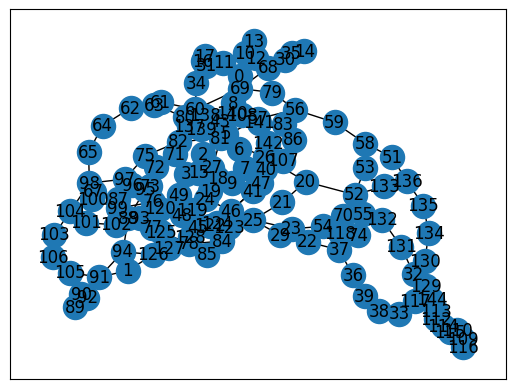

In [12]:
nx.draw_networkx(TT)

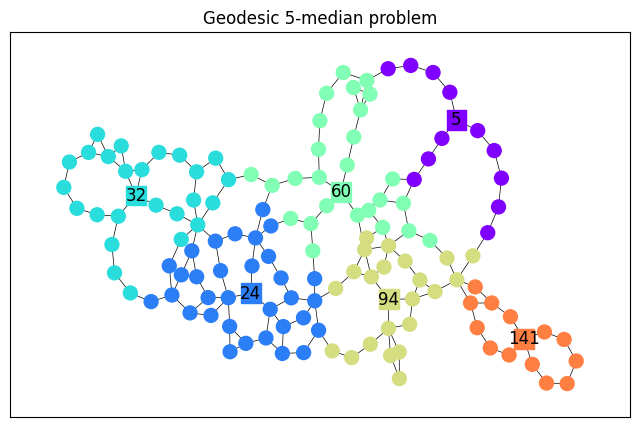

In [13]:
drawing(TT, result_dict, title_ex = 'Geodesic 5-median problem')

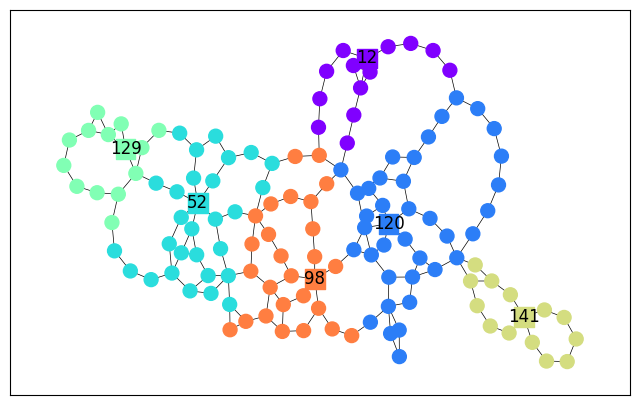

In [14]:
drawing(TT, result_dict_2)

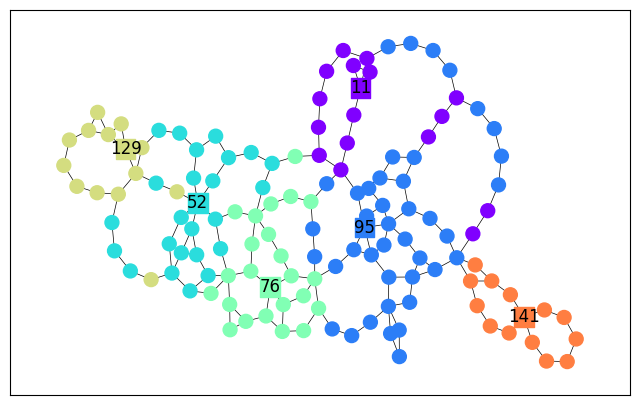

In [15]:
drawing(TT, result_dict_3)

In [16]:
def protected_distance_dict(graph, weight='weight', inf_par=10**5):
    # Проверяем, является ли граф двусвязным
    biconnected = graph.is_biconnected()

    # Предвычисляем все кратчайшие пути с использованием алгоритма Дейкстры для оригинального графа
    all_shortest_paths = graph.distances(weights=weight)
    
    # Создаем копию для хранения результатов
    res_dict = [list(row) for row in all_shortest_paths]

    # Перебор всех рёбер
    for edge_id in tqdm(range(graph.ecount())):
        # Используем deepcopy для копирования графа
        temp_graph = deepcopy(graph)
        temp_graph.delete_edges(edge_id)

        # Убедимся, что все рёбра в temp_graph имеют числовой вес
        for edge in temp_graph.es:
            if not isinstance(edge['weight'], (int, float)) or pd.isnull(edge['weight']):
                edge['weight'] = 1

        # Пересчитываем все кратчайшие пути после удаления рёбра
        cur_shortest_paths = temp_graph.distances(weights=weight)

        # Сравниваем и обновляем результаты
        for u in range(graph.vcount()):
            for v in range(graph.vcount()):
                if cur_shortest_paths[u][v] == float('inf'):
                    cur_shortest_paths[u][v] = inf_par + all_shortest_paths[u][v]  # Или любое другое большое число
                if cur_shortest_paths[u][v] > res_dict[u][v]:
                    res_dict[u][v] = cur_shortest_paths[u][v]
                    
    # Преобразуем res_dict в словарь с использованием имен вершин
    distance_dict = {}
    for u in range(graph.vcount()):
        for v in range(graph.vcount()):
            vertex_u = graph.vs[u]["name"]
            vertex_v = graph.vs[v]["name"]
            distance_dict[(vertex_u, vertex_v)] = res_dict[u][v]

    return distance_dict, biconnected

def plot_multiple_quantile_distributions(distances_list, labels):
    plt.figure(figsize=(8, 5))
    
    # Перебираем все наборы данных и рисуем для каждого квантильное распределение
    for distances, label in zip(distances_list, labels):
        quantiles = np.percentile(distances, np.linspace(0, 100, 101))
        plt.plot(np.linspace(0, 100, 101), quantiles, label=label)
    
    plt.xlabel('Percentile')
    plt.ylabel('GUF Distance')
    plt.title('Quantile Distribution of Distances')
    plt.legend(title='Distance Types')
    plt.show()

In [17]:
prot_dict, bi = protected_distance_dict(TT_ig, weight='weight')

100%|██████████| 177/177 [00:00<00:00, 227.99it/s]


In [18]:
result_list = []
for i in result_dict.keys():
    #print(i)
    for u in result_dict[i]:
        #print(i, u)
        try:
            # Попытка взять значение из prot_dict[i][u]
            value = prot_dict[(i, u)]
        except KeyError:
            try:
                # Если не получилось, пытаемся взять из prot_dict[u][i]
                value = prot_dict[(u, i)]
            except KeyError:
                # Если ни один ключ не найден, можно установить значение по умолчанию или пропустить
                value = None  # Или continue, если нужно пропустить
        result_list.append(int(value))

In [19]:
result_list_2 = []
for i in result_dict_2.keys():
    #print(i)
    for u in result_dict_2[i]:
        #print(i, u)
        try:
            # Попытка взять значение из prot_dict[i][u]
            value = prot_dict[(i, u)]
        except KeyError:
            try:
                # Если не получилось, пытаемся взять из prot_dict[u][i]
                value = prot_dict[(u, i)]
            except KeyError:
                # Если ни один ключ не найден, можно установить значение по умолчанию или пропустить
                value = None  # Или continue, если нужно пропустить
        result_list_2.append(int(value))

In [20]:
result_list_3 = []
for i in result_dict_3.keys():
    #print(i)
    for u in result_dict_3[i]:
        #print(i, u)
        try:
            # Попытка взять значение из prot_dict[i][u]
            value = prot_dict[(i, u)]
        except KeyError:
            try:
                # Если не получилось, пытаемся взять из prot_dict[u][i]
                value = prot_dict[(u, i)]
            except KeyError:
                # Если ни один ключ не найден, можно установить значение по умолчанию или пропустить
                value = None  # Или continue, если нужно пропустить
        result_list_3.append(int(value))

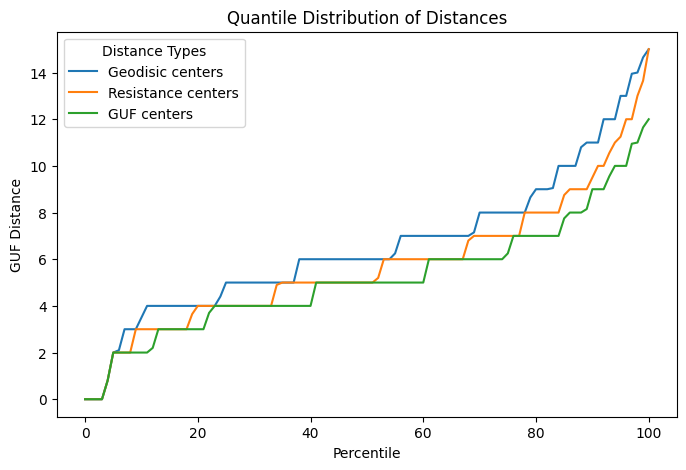

In [21]:
plot_multiple_quantile_distributions([result_list, result_list_2, result_list_3], ['Geodisic centers', 'Resistance centers', 'GUF centers'])

In [22]:
df = pd.DataFrame({
    'geodesic': result_list,
    'resistance': result_list_2,
    'protected': result_list_3
})

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
df.describe(percentiles=quantiles)

,geodesic,resistance,protected
count,136.000000,136.000000,136.000000
mean,6.588235,5.757353,5.198529
std,3.158693,2.907198,2.520493
min,0.000000,0.000000,0.000000
10%,3.500000,3.000000,2.000000
20%,4.000000,4.000000,3.000000
30%,5.000000,4.000000,4.000000
40%,6.000000,5.000000,4.000000
50%,6.000000,5.000000,5.000000
60%,7.000000,6.000000,5.000000
